In [1]:
# -*- coding: utf-8 -*-
"""
Tools for Pressure induced by Laser plasma evaluation from esther code in ns scale - see reference for limits and validation 
@author: Scius_Bertrand, Laurent Berthe from

# Bibtex - Citation - reference. 
@article{Scius-Bertrand_2021, doi = {10.1088/1361-6463/abc040}, url = {https://dx.doi.org/10.1088/1361-6463/abc040}, year = {2020}, month = {nov}, publisher = {IOP Publishing}, volume = {54}, number = {5}, pages = {055204}, author = {Marine Scius-Bertrand and Laurent Videau and Alexandre Rondepierre and Emilien Lescoute and Yann Rouchausse and Jan Kaufman and Danijela Rostohar and Jan Brajer and Laurent Berthe}, title = {Laser induced plasma characterization in direct and water confined regimes: new advances in experimental studies and numerical modelling}, journal = {Journal of Physics D: Applied Physics}, abstract = {Optimization of the laser shock peening (LSP) and LASer Adhesion Test (LASAT) processes requires control of the laser-induced target’s loading. Improvements to optical and laser technologies allow plasma characterization to be performed with greater precision than 20 years ago. Consequently, the processes involved during laser–matter interactions can be better understood. For the purposes of this paper, a self-consistent model of plasma pressure versus time is required. The current approach is called the inverse method, since it is adjusted until the simulated free surface velocity (FSV) corresponds to the experimental velocity. Thus, it is not possible to predict the behavior of the target under shock without having done the experiments. For the first time, experimental data collected in different labs with the most up-to-date laser parameters are used to validate a self-consistent model for temporal pressure-profile calculation. In addition, the parameters characterizing the plasma (temperature, thickness and duration) are obtained from the ESTHER numerical code, together with the amount of ablated matter. Finally, analytic fits are presented that can reproduce any pressure–temporal profiles in the following domains of validity: intensities, I, ranging from 10 to 500 GW cm−2 and pulse durations, T pul, between 5 and 40 ns for the direct-illumination regime at 1053 nm, I ranging from 1 to 6 GW cm−2 and T pul between 10 to 40 ns in the water-confined regime at 1053 nm, and I from 1 to 10 GW cm−2 and T pul between 7 and 20 ns in the water-confined regime at 532 nm. These temporal pressure profiles can then be used to predict the aluminum target’s behavior under laser shock using mechanical simulation software.} }


"""
import os, sys
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from math import exp,pi,cos,sin #power density

# Graph, X,Y data with title, labels and axis YX, limits as input.  
def graph (x,y,title,labelx,labely,xmin,xmax,ymin,ymax):
    plt.figure(figsize=(6.0, 6.0))
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.title(title)
    plt.grid(color='black', linestyle='--', linewidth=0.5)
    plt.axis((xmin,xmax,ymin,ymax))
    #plt.scatter(x,y,lw=4)
    plt.plot(x,y)
    plt.savefig(title+'.png')
    

    return

#calculate power density (GW/cm2), Fluence in (cm2 and m2) on target from pulse duration Tau(ns), Energy E(J), Spot diameter (cm), Neutral Density 

def LaserPowerDensity(Tau,E,d,D0): 
    
    #Attenuation=np.log10(D0)
    Attenuation=10**(-D0)
    E=abs(Attenuation*E)
    #np.log(10)
    print ("Attenuation factor from D0 :", Attenuation)
    print ("Energie sur cible :",E)

    S=pi*(d/2)*(d/2) #cm2
    Fluencecm2=E/S #J/cm2
    Fluencem2=Fluencecm2*10000
    I0 = E/S/Tau #GW/cm2

    print ('Power density(GW/cm2) = ', I0)
    print ('Fluence (J/Cm2) = ',Fluencecm2)
    print ('Fluence (J/m2) = %E'%(Fluencem2))
    return I0,Fluencecm2, Fluencem2 


def MaxPressureAtMaxPowerDensity(PowerDensity): #in GPA, PowerDensity in GW/cm2
#calculate Pressure plasma in GPA as function of PowerDensity in GW/cm2 in direct interaction. 
    if PowerDensity <= 100 :
        Pmax = (0.56 + 0.08*PowerDensity- 3.2*10**(-4)*PowerDensity**2)
    
    else:
        Pmax = 2.52 + 0.0238*PowerDensity
    
    return Pmax

def PowerDensityPressure(IMax,Np):
#calculate Pressure plasma in GPA as function of PowerDensity in GW/cm2 in direct interaction from 0 to Imax with Np points    
    DImax=Imax/Np
    DataPmax=[]
    DataImax=[]
    
    for i in range(Np):
        PowerDensity=i*DImax
        Pmax=MaxPressureAtMaxPowerDensity(PowerDensity)
        DataPmax.append(Pmax)
        DataImax.append(PowerDensity)

    #trace    
    plt.close()  
    #plt.yscale('log')
    plt.plot( DataImax,DataPmax,label='Scale Law')
    plt.xlabel('Power Density (GW/cm2)')
    plt.ylabel('Maximum Plasma Pressure (GPa)')
    plt.title('Maximum Pressure plasma as function of Power Density')
    plt.legend()
    plt.grid()
    plt.show()
    return


def PressureFunction(Time,Imax,Tpul,T0,Ti):
# Pressure Temporal profile at function from maximu pression Pmax (GPa) at T0 (ns), pulse duration Tpul (ns) 
# output: pressure (GPa) time Time (ns)    
    #Calculation Pmax et Pi,Ti,Pm
    Ti = 3/2.*Tpul
    I1 =(1.1 - 9.76 * 10**(-3)*Tpul)*Imax
    I2 = (0.84 + 0.016*Tpul)*Imax

    if Imax <= 100 :
        Pmax = (0.56 + 0.08*Imax- 3.2*10**(-4)*Imax**2)
        Pm = 0.092 * Imax**0.623
#else 100 <= I :
    else:
        Pmax = 2.52 + 0.0238*Imax
        Pm = 0.162 + 0.0166*Imax


    if I1 <= 240 - 3.4*Tpul :
        Pi= 0.11 + 0.011*I1
    elif I1 >= 240 - 3.4*Tpul :
        Pi= (2.79 -0.09*Tpul + 1.12*10**(-3)*Tpul**2)+2*10**(-3)*I1
    

    n = (0.5 + 1.76*10**(-2)*Tpul)*np.exp(-((I2-115)/100)**2)+1.14 - 1.06*10**(-2)*Tpul +1.37 *10**(-4)*Tpul**2
    delta = 0.83 - (0.467 - 2.45 * 10**(-3)*Tpul +1.75*10**(-4)*Tpul**2)*np.exp(-((I2- 100)/(100))**2)
    p = (np.log(Pmax/Pm))/(np.log(40/T0))
    
    if Time <= T0 :
        return Pmax*(Time/T0)
    elif T0 <=Time and Time<= Tpul:
            return Pmax*(T0/Time)**p
    elif Tpul <Time and Time< Ti:
            return ((PressureFunction(Ti,Imax,Tpul,T0,Ti)-PressureFunction(Tpul,Imax,Tpul,T0,Ti))/(Ti-Tpul))*Time+PressureFunction(Ti,Imax,Tpul,T0,Ti)-((PressureFunction(Ti,Imax,Tpul,T0,Ti)-PressureFunction(Tpul,Imax,Tpul,T0,Ti)))/(Ti-Tpul)*Ti
    elif Ti <=Time:
        return Pi*((Ti-Ti*delta)/(Time-Ti*delta))**n
    return


def PressureProfile(I0,Tpul,T0,Np,FileName):
#Calculate full Pressure Profile from max power density (GW.cm2) at T0 (ns), Pulse duration Tpul(ns) on Np value up to Tpulx4
#save data in FileName 
#Graph profile    
    Times=np.linspace(0,Tpul*10,Np)
    Pt=[]
    Ti= 3/2.*Tpul
    
    #profile calculation
    for jx in range(Np):
        Pt.append(PressureFunction(Times[jx],I0,Tpul,T0,Ti))
    
    print ("Max Power Density (GW/cm2) :", I0)
    print ("Pulse Duration (ns) :",Tpul)
    print ("Pmax (GPa) : ",np.max(Pt))
    print ("Ti (ns) :",Ti)

    fichier=open(FileName,'w')
    for jx in range(Np):
        texte='%16.8e' %(Times[jx])
        texte+='%16.8e' %(Pt[jx])
        fichier.write(texte.strip()+'\n')
    fichier.close()
    print ("Profile save in ", FileName)
    
    plt.close()
    plt.title('Pulse duration (ns) : '+ str(Tpul)+' Power Density (GW/cm2) : '+ str(I0))
    plt.plot(Times,Pt,label='P(t)')
    plt.plot([T0,T0],[np.min(Pt),np.max(Pt)],'--',label='T0')
    plt.plot([Tpul,Tpul],[np.min(Pt),PressureFunction(Tpul,I0,Tpul,T0,Ti)],'--',label='Tpul')
    plt.plot([Ti,Ti],[np.min(Pt),PressureFunction(Ti,I0,Tpul,T0,Ti)],'--',label='Ti')
    plt.legend()

    plt.xlabel('Time (ns)')
    plt.ylabel('Plasma Pressure (GPa)')
    plt.grid()
    plt.xlim(-10)
    plt.show()
    return


# Laser Parameters Evaluation & corresponding pressure profile from squate pulses. 

Attenuation factor from D0 : 1.0
Energie sur cible : 400.0
Power density(GW/cm2) =  3395.3054526271003
Fluence (J/Cm2) =  50929.581789406504
Fluence (J/m2) = 5.092958E+08
Max Pressure at  3395.3054526271003  GW/cm2 in GPa :  83.32826977252499
Max Power Density (GW/cm2) : 3395.3054526271003
Pulse Duration (ns) : 15
Pmax (GPa) :  80.37101766802057
Ti (ns) : 22.5
Profile save in  TimePressureProfile.txt


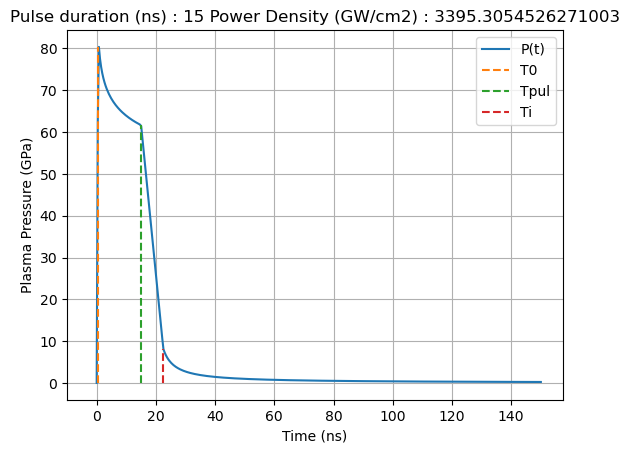

In [2]:
#laser parameters
Tpul=15#ns
E=400 #J - Native Laser energy
d=0.1 #cm
#Attenuation if neutral density 
D0=0.0

#Laser loading calculation
I0, Fluencecm2,Fluencem2 = LaserPowerDensity(Tpul,E,d,D0)
T0=0.5 #Rise Time
#corresponding Plasma Pressure
print("Max Pressure at ", I0, " GW/cm2 in GPa : ",MaxPressureAtMaxPowerDensity(I0))

#Pressure Profile on Np points save in Filename
Np=400
FileName="TimePressureProfile.txt"
PressureProfile(I0,Tpul,T0,Np,FileName)

## Pression/Flux

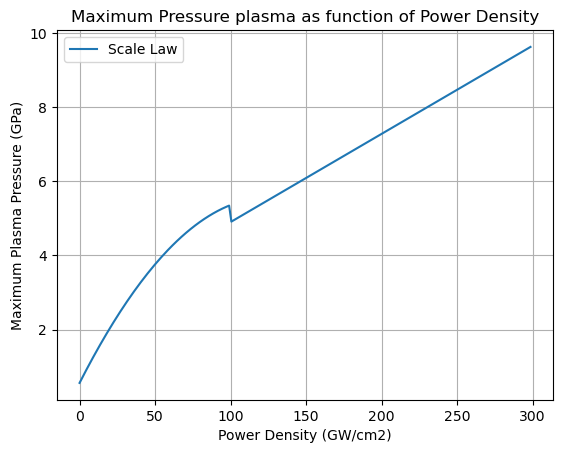

In [3]:
#Calcul Pmax et Pi,Ti,Pm
Imax=300
Np=200
PowerDensityPressure(Imax,Np)